# Brain tumor segmentation

- The segmentation-models-pytorch is a deep learning package used for image segmentation tasks 

In [ ]:
pip install seaborn

In [1]:
# installing packages
# this is a very large package take your time 
pip install --default-timeout=120 segmentation-models-pytorch

In [3]:
pip install -q opencv-python # -q for quiet

In [4]:
pip install -q albumentations

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os # provides a way to interact with the operating system
import time
from glob import glob # used for pattern matching files and directories in a file system.
from tqdm import tqdm # progress indicator for tasks that involve iteration

In [27]:
import cv2 # open source computer vision package used computer vision
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import albumentations as A # for image augmentation 
from scipy.ndimage.morphology import binary_dilation # used for morphological operations on binary (boolean) images
import segmentation_models_pytorch as smp
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split


/tmp/ipykernel_3069/3542489440.py:7: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation # used for morphological operations on binary (boolean) images


In [3]:
import torch
from torch.optim import Adam # Adaptive Moment Estimation is an optimization algorithm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset ,DataLoader
from torchvision import transforms as T

In [4]:
# check for CUDA compatible GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing

In [5]:
# getting files 
files_dir = '/media/danlof/USB STICK/MRI/kaggle_3m'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')

# loading files 
csv_path = '/media/danlof/USB STICK/MRI/kaggle_3m/data.csv'
mri_df = pd.read_csv(csv_path)
mri_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [23]:
mri_df.describe()

,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
count,92.000000,109.000000,110.000000,108.000000,98.000000,105.000000,110.000000,109.000000,109.000000,109.0,109.000000,109.000000,109.000000,109.000000,108.000000,102.000000,109.000000
mean,2.445652,3.678899,1.900000,1.722222,2.367347,1.895238,1.763636,2.128440,1.532110,1.0,2.009174,3.513761,1.486239,45.834862,2.907407,1.970588,0.247706
std,1.180092,1.169684,0.789263,0.862872,1.125045,0.663960,0.855927,0.850935,0.501273,0.0,0.995317,1.863960,0.502119,13.797151,0.291212,0.169792,0.433674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,20.000000,2.000000,1.000000,0.000000
25%,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,2.000000,1.000000,34.000000,3.000000,2.000000,0.000000
50%,2.000000,4.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.0,2.000000,2.000000,1.000000,47.000000,3.000000,2.000000,0.000000
75%,4.000000,5.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,58.000000,3.000000,2.000000,0.000000
max,4.000000,5.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,75.000000,3.000000,2.000000,1.000000


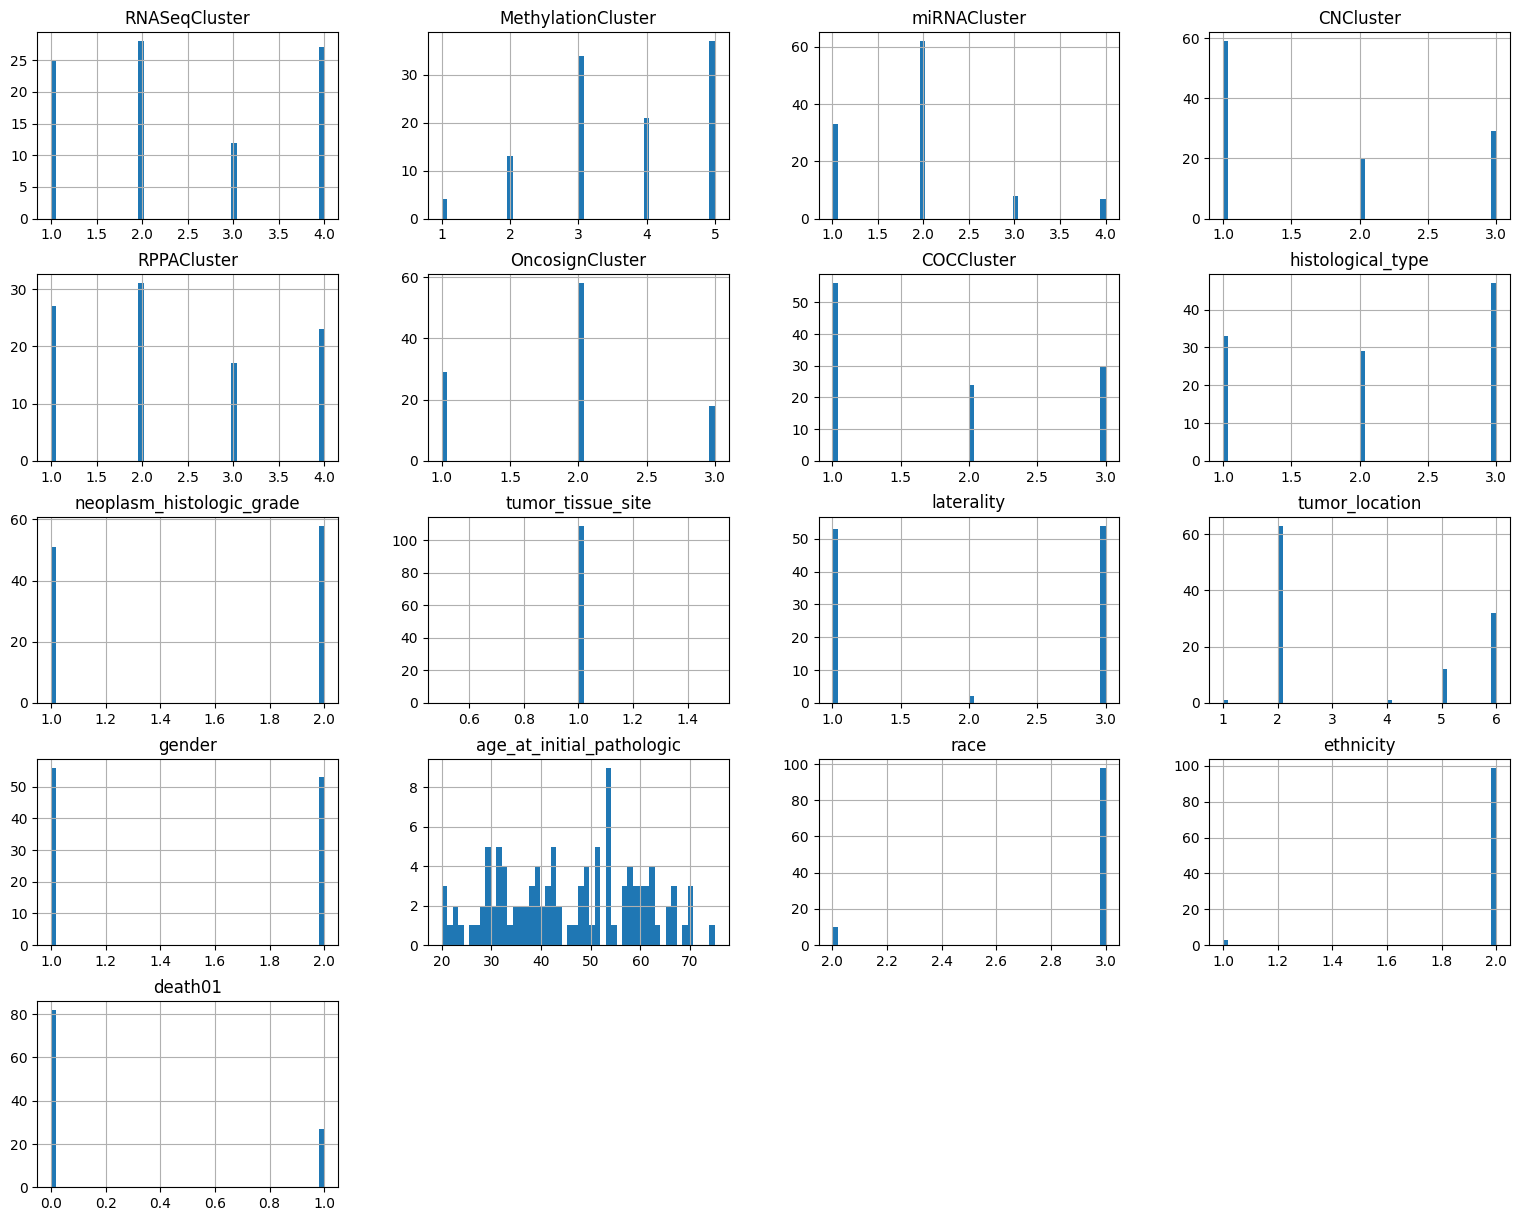

In [25]:
%matplotlib inline
mri_df.hist(bins = 50 ,figsize= (19,15))
plt.show()

## How to handle missing values

- I will be having the simple imputer on the most frequent when dealing with missing values and 
- I will also perform KNN imputation and compare both for accuracy

- 1. Simple Imputer

In [16]:
imputer = SimpleImputer(missing_values=np.nan,strategy= 'most_frequent')
imputer = imputer.fit(mri_df.values)
df_SI = pd.DataFrame(imputer.transform(mri_df.values),columns=mri_df.columns)
df_SI.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,2.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,0.0
3,TCGA_CS_4944,2.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,2.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,2.0,0.0


- 2. KNN imputer

In [37]:
# specify the number of k neighbours
n_neighbours = 5
# create a KNN imputer instance
knn_imputer = KNNImputer(n_neighbors=n_neighbours)
# fit the knn imputer
df_knn = knn_imputer.fit_transform(mri_df)
df_knn = pd.DataFrame(df_knn,columns = mri_df.columns)

ValueError: could not convert string to float: 'TCGA_CS_4941'

### Checking for Skewness

In [17]:
import pandas as pd
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns 

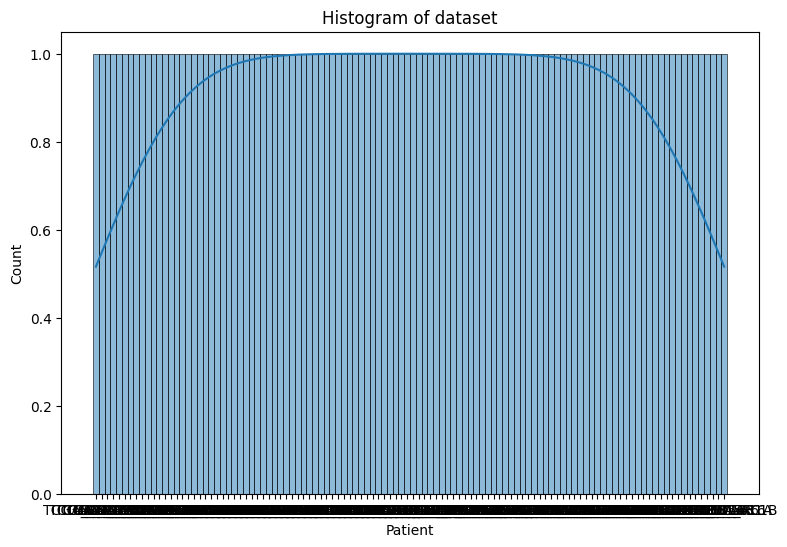

In [22]:
plt.figure(figsize=(9,6))
sns.histplot(df_SI[columns],kde=True)
plt.title('Histogram of dataset')
plt.show()